# Información No Estructurada: PRACTICA 1

Autores: Íñigo Gómez Carvajal y Jon Zorrilla Gamboa

# 1. Funciones de ranking no supervisado.

Dada una pequeña colección "de juguete", calcular el ranking de búsqueda para varias consultas según las siguientes funciones de ranking no supervisado:

<ol type="a">
<li> Coseno TF-IDF (modelo vectorial).
<li> BM25.
<li> Query likelihood.
</ol>

In [1]:
import numpy as np
from statistics import mean

### Definir las funciones de ranking a continuación.

In [ ]:
class VSM:
  def __init__(self, freqvector, docfreqs):
    self.freqvector = freqvector
    self.docfreqs = docfreqs

  def search(self, q):
    # Calculamos los cosenos de todos los documentos.
    ranking = [(url, self.dotproduct(url, q) /  self.module(url)) for url in self.freqvector]
    # Eliminamos los documentos con coseno = 0.
    ranking = [(url, cos) for url, cos in ranking if cos > 0]
    # Ordenamos.
    ranking.sort(key=lambda x: x[1], reverse=True)
    return ranking
    
  def dotproduct(self, url, q):
    # Código aquí
    # ...
    product = 0
    for i in q:
      product += self.tf(i, url)*self.idf(i)

    return product

  def module(self, url):
    # Código aquí
    # ...
    return np.linalg.norm(list(self.freqvector[url].values())) #freq


  def tf(self, word, url):
    # Código aquí
    # ...
    if self.freqvector[url][word] > 0:
      return 1 + np.log2(self.freqvector[url][word])
    else:
      return 0

  def idf(self, word):
    return np.log2((len(self.freqvector)+1)/(self.docfreqs[word]+0.5))

# Nota: cuando una palabra aparece en más de la mitad de la colección, resulta un score BM25 negativo. 
# Una forma de evitarlo es tomar un número mínimo de documentos como |D|, es decir usar por ejemplo 
# |D| = min(20, len(freqvector)) 
class BM25:
  def __init__(self, freqvector, docfreqs, b, k):
    self.freqvector = freqvector
    self.docfreqs = docfreqs
    self.b = b
    self.k = k

  def search(self, q):
    ranking = [(url, self.f_qd(q, url)) for url in self.freqvector]
    # Código aquí
    # ...
    ranking.sort(key=lambda x: x[1], reverse=True)
    return ranking

  def RSJ(self, word):

    rsj = np.log((max(len(self.freqvector), 20) - self.docfreqs[word] + 0.5) / 
                 (self.docfreqs[word] + 0.5))
    return rsj

  def f_qd(self, q, url):

    doclen = sum(self.freqvector[url].values())
    avg_doclen = mean([sum(self.freqvector[i].values()) for i in freqvector])

    result=0

    for word in q:
      result += (((self.k + 1) * self.freqvector[url][word]) /
                 (self.k * (1 - self.b + self.b * doclen / avg_doclen) +
                  self.freqvector[url][word]) * self.RSJ(word))
    
    return result

class QLD:
  def __init__(self, freqvector, wordfreqs, mu):
    self.freqvector = freqvector
    self.wordfreqs = wordfreqs
    self.mu = mu
    self.p_hat = self.p_hat_dict(q)

  def search(self, q):
    ranking = [(url, self.p_qd(q, url)) for url in self.freqvector]
    ranking.sort(key=lambda x: x[1], reverse=True)
    return ranking

  def p_qd(self, q, url):
    
    result = 1
    doclen = sum(self.freqvector[url].values())
    for word in q:
      result *= ((self.freqvector[url][word] + self.mu*self.p_hat[word]) /
                 (doclen + self.mu))
      
    return result

  def p_hat_dict(self, q):

    p_hat = {}
    total_len = sum([sum(self.freqvector[url].values()) for url in self.freqvector])

    for word in q:
      wordfreq = sum([self.freqvector[url].get(word, 0) for url in self.freqvector])
      p_hat[word] = wordfreq / total_len

    return p_hat



### Programa de prueba

In [ ]:
from urllib.request import urlopen
from bs4 import BeautifulSoup
from collections import Counter
import re

# La colección: una pequeña lista de URLs web.
urls = ["https://en.wikipedia.org/wiki/Age_of_Enlightenment",
        "https://en.wikipedia.org/wiki/Rationalism",
        "https://en.wikipedia.org/wiki/Scientific_Revolution",
        "https://en.wikipedia.org/wiki/French_Revolution",
        "https://en.wikipedia.org/wiki/Winner%27s_curse",
        "https://en.wikipedia.org/wiki/Simpson%27s_paradox",
        "https://en.wikipedia.org/wiki/Friendship_paradox",
        "https://en.wikipedia.org/wiki/Condorcet_paradox",
        "https://en.wikipedia.org/wiki/Paradox_of_value",
        "https://en.wikipedia.org/wiki/Ship_of_Theseus"
       ]

# Leemos los documentos y quitamos las marcas HTML.
texts = [BeautifulSoup(urlopen(url).read(), "lxml").text.lower() for url in urls]

# Una lista ad-hoc de stopwords.
stoplist = ["also", "could", "p", "pp", "th", "however", "one", "two", "many", "i", "de", "la", "me", "my", "myself", "the", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself", "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself", "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "these", "those", "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", "until", "while", "of", "at", "by", "for", "with", "about", "against", "between", "into", "through", "during", "before", "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again", "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", "both", "each", "few", "more", "most", "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so", "than", "too", "very", "s", "t", "can", "will", "just", "don", "should", "now"]

In [ ]:
# Nos abstraemos de los detalles reales de indexación, y utilizaremos un manejo muy simplificado del texto.

# Vector de frecuencias para todos los documentos de la colección, usando la subclase de diccionario collections.Counter.
# Para cada documento, separamos el texto en lista de palabras, y Counter genera un diccionario palabra:frecuencia.
# Se construye un diccionario url -> word -> count (se denomina un "índice forward").
freqvector = {url:Counter([word for word in re.findall(r"[^\W\d_]+|\d+", text) if word not in stoplist]) for url, text in zip(urls, texts)}
# Guardamos el vocabulario (el conjunto de todas las palabras que apaercen en los documentos de la colección).
vocabulary = set()
for word in freqvector.values(): vocabulary.update(word)

# Document frequency de cada palabra del vocabulario: nº de documentos que contienen la palabra.
docfreqs = {word:len([url for url in freqvector if word in freqvector[url]]) for word in vocabulary}

# Frecuencia total para cada palabra del vocabulario: nº total de apariciones en la colección.
wordfreqs = {word:sum([freqvector[url][word] for url in freqvector if word in freqvector[url]]) for word in vocabulary}

# Probamos tres consultas.

for q in [['descartes', 'montesquieu'], ['thought', 'experiment', 'identity'], ['market', 'paradox']]:
  print('\n------------------------------')
  print('Query:', q)
  print('\nModelo vectorial')
  for url, score in VSM(freqvector, docfreqs).search(q):
    print(score, url)
  print('\nBM25')
  for url, score in BM25(freqvector, docfreqs, b=0.5, k=1).search(q):
    print(score, url)
  print('\nQuery likelihood + Dirichlet')
  for url, score in QLD(freqvector, wordfreqs, mu=3000).search(q):
    print(score, url)
# np.linalg.norm(list(freqvector["https://en.wikipedia.org/wiki/Age_of_Enlightenment"].values())) #freq
# docfreqs #D_t


------------------------------
Query: ['descartes', 'montesquieu']

Modelo vectorial
0.019416589532343955 https://en.wikipedia.org/wiki/Age_of_Enlightenment
0.018942313176857278 https://en.wikipedia.org/wiki/Rationalism
0.011618546236635252 https://en.wikipedia.org/wiki/Scientific_Revolution
0.005583086872120888 https://en.wikipedia.org/wiki/French_Revolution

BM25
6.1853670211465115 https://en.wikipedia.org/wiki/Age_of_Enlightenment
3.121705926687511 https://en.wikipedia.org/wiki/Rationalism
2.691210463493585 https://en.wikipedia.org/wiki/Scientific_Revolution
2.5191751687269623 https://en.wikipedia.org/wiki/French_Revolution
0.0 https://en.wikipedia.org/wiki/Winner%27s_curse
0.0 https://en.wikipedia.org/wiki/Simpson%27s_paradox
0.0 https://en.wikipedia.org/wiki/Friendship_paradox
0.0 https://en.wikipedia.org/wiki/Condorcet_paradox
0.0 https://en.wikipedia.org/wiki/Paradox_of_value
0.0 https://en.wikipedia.org/wiki/Ship_of_Theseus

Query likelihood + Dirichlet
1.9666942569311674e-07 

# 2. Búsqueda con funciones no supervisadas implementadas en la librería PyTerrier.

### Ejemplo

In [ ]:
# Utlizamos la librería de motor de búsqueda PyTerrier.
!pip install python-terrier
!pip install ir-measures
import pyterrier as pt
from pyterrier.measures import *
if not pt.started(): pt.init()

def printsearch(name, model, q):
  print('\n' + name)
  # Eliminamos todas las columnas del dataframe menos score y docno
  print((model).search(q)[['score', 'docno']].to_string(index=False))

def eval(names, models, queries, qrels, metrics, sort=[], baseline=None):
  # La clase Experiment ejecuta rankers sobre una batería de consultas, y calcula métricas.
  # El parámetro "baseline" hace que se añadan p-valores (y nº de consultas ganadas/perdidad) respecto a uno de los rankers.
  # Con el parámetro "sort" se ordena la tabla de métricas la métrica que se indique.
  print(pt.Experiment(models, queries, qrels, metrics, names, baseline=baseline).sort_values(str(sort), ascending=False).to_string(index=False))

# Accedemos a una colección "Vaswani" ya construida e indexada en PyTerrier.
dataset = pt.datasets.get_dataset('vaswani')
index = pt.IndexFactory.of(dataset.get_index('terrier_stemmed_text'))
queries = dataset.get_topics()
qrels = dataset.get_qrels()

# Sacamos una consulta cualquiera del conjunto de datos para probar los rankers.
q = queries[queries.qid=='5']['query'].values[0]

# Creamos y probamos rankers no supervisados por VSM, BM25, QLD y otros.
vsm = pt.BatchRetrieve(index, wmodel='TF_IDF')
bm25 = pt.BatchRetrieve(index, wmodel='BM25F')
qld = pt.BatchRetrieve(index, wmodel='DirichletLM')
pl2 = pt.BatchRetrieve(index, wmodel='PL2')
dph = pt.BatchRetrieve(index, wmodel='DPH')
print('Query:', q)
# El operador "%n" de PyTerrier pide al modelo que produzca sólo el top n del ranking.
printsearch('Modelo vectorial', vsm%10, q)
printsearch('BM25', bm25%10, q)
printsearch('Query likelihood Dirichlet', qld%10, q)

# Calculamos varias métricas
eval(['Modelo vectorial', 'BM25', 'Query likelihood Dirichlet', 'DFR Poisson Laplace', 'DFR DPH'],
     [vsm%50, bm25%50, qld%50, pl2%50, dph%50],
     queries, qrels, [P@10, nDCG, nDCG@10, RR], baseline=0, sort=nDCG@10)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.4/104.4 KB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.6/69.6 KB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.5/311.5 KB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 KB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 286.6/286.6 KB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.1/45.1 KB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.6/72.6 KB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.8/114

PyTerrier 0.9.2 has loaded Terrier 5.7 (built by craigm on 2022-11-10 18:30) and terrier-helper 0.0.7



data.direct.bf:   0%|          | 0.00/388k [00:00<?, ?iB/s]

data.document.fsarrayfile:   0%|          | 0.00/234k [00:00<?, ?iB/s]

data.inverted.bf:   0%|          | 0.00/362k [00:00<?, ?iB/s]

data.lexicon.fsomapfile:   0%|          | 0.00/682k [00:00<?, ?iB/s]

data.lexicon.fsomaphash:   0%|          | 0.00/777 [00:00<?, ?iB/s]

data.lexicon.fsomapid:   0%|          | 0.00/30.3k [00:00<?, ?iB/s]

data.meta-0.fsomapfile:   0%|          | 0.00/725k [00:00<?, ?iB/s]

data.meta.idx:   0%|          | 0.00/89.3k [00:00<?, ?iB/s]

data.meta.zdata:   0%|          | 0.00/2.07M [00:00<?, ?iB/s]

data.properties:   0%|          | 0.00/4.31k [00:00<?, ?iB/s]

md5sums:   0%|          | 0.00/619 [00:00<?, ?iB/s]

query-text.trec:   0%|          | 0.00/3.05k [00:00<?, ?iB/s]

qrels:   0%|          | 0.00/6.63k [00:00<?, ?iB/s]

Query: use of programs in engineering testing of computers

Modelo vectorial
    score docno
14.442821  1586
12.833733 11429
10.506225  7875
 9.889541  3559
 9.809790  2290
 9.737880  5130
 9.486759  4307
 9.451995  4308
 9.403773  9165
 9.344073 10156

BM25
    score docno
28.368006  1586
23.553835 11429
20.804721  2290
20.194568  7875
19.803231 10156
19.295740  5130
19.203330  3559
17.927556  2927
17.740540   148
17.598424  2511

Query likelihood Dirichlet
   score docno
3.305896  1586
3.287824  2373
3.002635 11429
2.937968  3559
2.570817  4307
2.495430  4709
2.434525   276
2.379995  5538
2.292910  7875
2.283731  4308
                      name       RR     P@10     nDCG  nDCG@10  RR +  RR -  RR p-value  P@10 +  P@10 -  P@10 p-value  nDCG +  nDCG -  nDCG p-value  nDCG@10 +  nDCG@10 -  nDCG@10 p-value
          Modelo vectorial 0.698671 0.359140 0.438444 0.444411   NaN   NaN         NaN     NaN     NaN           NaN     NaN     NaN           NaN        NaN        NaN              NaN


### Ejercicio: probar más modelos no supervisados y métricas de PyTerrier

La lista completa de rankers de PyTerrier está disponible en http://terrier.org/docs/current/javadoc/org/terrier/matching/models/package-summary.html.

La lista de métricas en https://pyterrier.readthedocs.io/en/latest/experiments.html.

**Solución:** Los modelos que vamos a probar son MDL2, DFIZ, BB2 y DRFree. En cuanto a las métricas dejamos nDCG para seguir teniendo una comparativa conocida, pero probamos R (Recall) y AP (Mean Average Precision)

In [ ]:
mdl2 = pt.BatchRetrieve(index, wmodel='MDL2')
dfiz = pt.BatchRetrieve(index, wmodel='DFIZ')
bb2 = pt.BatchRetrieve(index, wmodel='BB2')
dfree = pt.BatchRetrieve(index, wmodel='DFRee')
print('Query:', q)

# Calculamos varias métricas
eval(['MDL2', 'DFIZ', 'BB2', 'DFRee'],
     [mdl2%50, dfiz%50, bb2%50, dfree%50],
     queries, qrels, [AP@10, R@10, nDCG@10], baseline=0, sort=nDCG@10)

Query: use of programs in engineering testing of computers
 name     R@10  nDCG@10    AP@10  R@10 +  R@10 -  R@10 p-value  nDCG@10 +  nDCG@10 -  nDCG@10 p-value  AP@10 +  AP@10 -  AP@10 p-value
  BB2 0.226286 0.463713 0.168963    52.0    15.0  2.269932e-06       61.0       17.0     7.348892e-10     61.0     17.0   6.781334e-09
 DFIZ 0.228588 0.453790 0.164089    50.0     9.0  4.316688e-07       66.0       15.0     2.916592e-10     65.0     16.0   3.575353e-09
DFRee 0.211797 0.434793 0.154304    46.0     7.0  2.309196e-06       63.0       15.0     2.483288e-10     62.0     16.0   7.709457e-09
 MDL2 0.139547 0.303337 0.090720     NaN     NaN           NaN        NaN        NaN              NaN      NaN      NaN            NaN


# 3. Learning to rank con características de texto.

### Ejemplo

In [ ]:
import numpy as np
import lightgbm as lgb

# Definimos el vector de características, e indicamos la función de ranking para el primer filtro de candidatos "first stage ranking".
fsr = pt.FeaturesBatchRetrieve(index, controls = {'wmodel': 'BM25'}, features=['SAMPLE', 'WMODEL:DirichletLM', 'WMODEL:PL2'])

# Vamos a usar el modelo GBDT LambdaMART implementado en LightGBM.
# Configuramos el modelo.
lmart = lgb.LGBMRanker(task='train',
    min_data_in_leaf=1,
    min_sum_hessian_in_leaf=100,
    max_bin=255,
    num_leaves=7,
    objective='lambdarank',
    metric='ndcg',
    # ndcg_eval_at=[1, 3, 5, 10],
    learning_rate= .1,
    importance_type='gain',
    verbose=-1,
    num_iterations=10)

# Enganchamos al modelo la salida del filtro de candidatos con su vector de características a utilizar
# en el modelo supervisado.
ltr = fsr >> pt.ltr.apply_learned_model(lmart, form='ltr')

# Particionamos los datos (las consultas) en entrenamiento (60%), validación (20%) y test (20%).
train, validation, test = np.split(queries, [int(.6*len(queries)), int(.8*len(queries))])

# Entrenamos el modelo usando los juicios de relevancia (qrels). Aunque los qrels incluyen los datos de
# test, la función fit sólo utiliza los juicios asociados a las consultas de entrenamiento y validación.
ltr.fit(train, qrels, validation, qrels)

# Ejecutamos el modelo entrenado sobre una consulta y observamos la salida.
printsearch('BM25 + LambdaMART', ltr%10, q)

# Evaluamos y comparamos.
eval(['Modelo vectorial', 'BM25', 'Query likelihood Dirichlet', 'DFR Poisson Laplace', 'DFR DPH', 'BM25 + LambdaMART'],
     [vsm%50, bm25%50, qld%50, pl2%50, dph%50, ltr%50],
     test, qrels, [P@10, nDCG, nDCG@10, RR], sort=nDCG@10, baseline=0)

/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's ndcg@1: 0.421053
[2]	valid_0's ndcg@1: 0.578947
[3]	valid_0's ndcg@1: 0.578947
[4]	valid_0's ndcg@1: 0.578947
[5]	valid_0's ndcg@1: 0.578947
[6]	valid_0's ndcg@1: 0.578947
[7]	valid_0's ndcg@1: 0.578947
[8]	valid_0's ndcg@1: 0.578947
[9]	valid_0's ndcg@1: 0.578947
[10]	valid_0's ndcg@1: 0.578947

BM25 + LambdaMART
   score docno
0.334114  1586
0.312029 11429
0.292130  7875
0.292130  3559
0.292130  2290
0.292130  5130
0.240518  4307
0.240518  4308
0.240518  9165
0.240518 10156
                      name       RR     P@10     nDCG  nDCG@10  RR +  RR -  RR p-value  P@10 +  P@10 -  P@10 p-value  nDCG +  nDCG -  nDCG p-value  nDCG@10 +  nDCG@10 -  nDCG@10 p-value
          Modelo vectorial 0.596739 0.247368 0.347220 0.304047   NaN   NaN         NaN     NaN     NaN           NaN     NaN     NaN           NaN        NaN        NaN              NaN
       DFR Poisson Laplace 0.568381 0.242105 0.329377 0.296378   3.0   2.0    0.299321     1.0     2.0      0.577753     5.0    12.0 

### Ejercicio: variaciones en learning to rank.

Explorar la configuración de parámetros de LambdaMART.

Probar otros métodos learning to rank de Terrier.

Opcional: probar otras características funcionales.

Intentar conseguir al menos una solución que mejore a todas las del ejemplo anterior.

**Solución:** La mejora que proponemos sencillamente hace uso de PL2, puesto que parece que funciona mejor que BM25 y por tanto una extensión del propio modelo tiene más opciones de funcionar mejor. Para el modelo de aprendizaje, lo que hacemos es tomar LightGBM pero haciendo un pequeño tuning de los parámetros. En este caso hemos decidido trastear con el número de iteraciones y learning rate, pero hemos descubierto que con aumentar el número de hojas que genera cada árbol obtenemos un modelo que es superior a los anteriores

In [ ]:
# Ejemplo de características funcionales custom.
import re
def _features(row):
  content = index.getMetaIndex().getItem('text', row['docid'])
  f1 = len(content)
  f2 = len(re.findall(r"[^\W\d_]+|\d+", content))
  return np.array([f1, f2])

extended_fsr = bm25 >> pt.FeaturesBatchRetrieve(index, ['SAMPLE', 'WMODEL:DirichletLM', 'WMODEL:PL2']) ** pt.apply.doc_features(_features)
extended_ltr = extended_fsr >> pt.ltr.apply_learned_model(lmart, form="ltr")
extended_ltr.fit(train, qrels, validation, qrels)
printsearch('Extended BM25 + LambdaMART', extended_ltr%10, q)
eval(['Extended BM25 + LambdaMART'], [extended_ltr%50], test, qrels, [P@10, nDCG, nDCG@10, RR], sort=nDCG@10)

lmart2 = lgb.LGBMRanker(task='train',
    min_data_in_leaf=1,
    min_sum_hessian_in_leaf=100,
    max_bin=255,
    num_leaves=10,
    objective='lambdarank',
    metric='ndcg',
    # ndcg_eval_at=[1, 3, 5, 10],
    learning_rate= .1,
    importance_type='gain',
    verbose=-1,
    num_iterations=10)

fsr2 = pl2 >> pt.FeaturesBatchRetrieve(index, features=['WMODEL:DirichletLM', 'WMODEL:BM25']) ** pt.apply.doc_features(_features)

# Vamos a usar el modelo GBDT LambdaMART implementado en LightGBM.
# Configuramos el modelo.

# Enganchamos al modelo la salida del filtro de candidatos con su vector de características a utilizar
# en el modelo supervisado.
ltr2 = fsr2 >> pt.ltr.apply_learned_model(lmart2, form='ltr')

# Entrenamos el modelo usando los juicios de relevancia (qrels). Aunque los qrels incluyen los datos de
# test, la función fit sólo utiliza los juicios asociados a las consultas de entrenamiento y validación.
ltr2.fit(train, qrels, validation, qrels)


eval(['Modelo vectorial', 'BM25', 'Query likelihood Dirichlet', 'DFR Poisson Laplace', 'DFR DPH', 'Extended BM25 + LambdaMART', 'Extended DFR DPH + LambdaMART'],
     [vsm%50, bm25%50, qld%50, pl2%50, dph%50, extended_ltr%50, ltr2%50],
     test, qrels, [P@10, nDCG, nDCG@10, RR], sort=nDCG@10, baseline=0)


/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's ndcg@1: 0.421053
[2]	valid_0's ndcg@1: 0.578947
[3]	valid_0's ndcg@1: 0.526316
[4]	valid_0's ndcg@1: 0.526316
[5]	valid_0's ndcg@1: 0.526316
[6]	valid_0's ndcg@1: 0.526316
[7]	valid_0's ndcg@1: 0.526316
[8]	valid_0's ndcg@1: 0.526316
[9]	valid_0's ndcg@1: 0.526316
[10]	valid_0's ndcg@1: 0.526316

Extended BM25 + LambdaMART
   score docno
0.335469  1586
0.323043 11429
0.311999  7875
0.285381  2290
0.285381  5130
0.245035  3559
0.245035  2927
0.245035  2511
0.245035  4308
0.245035  2675
                      name     P@10     nDCG  nDCG@10       RR
Extended BM25 + LambdaMART 0.231579 0.328369 0.271001 0.520541


/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's ndcg@1: 0.105263
[2]	valid_0's ndcg@1: 0.578947
[3]	valid_0's ndcg@1: 0.631579
[4]	valid_0's ndcg@1: 0.578947
[5]	valid_0's ndcg@1: 0.578947
[6]	valid_0's ndcg@1: 0.578947
[7]	valid_0's ndcg@1: 0.578947
[8]	valid_0's ndcg@1: 0.578947
[9]	valid_0's ndcg@1: 0.578947
[10]	valid_0's ndcg@1: 0.631579
                         name       RR     P@10     nDCG  nDCG@10  RR +  RR -  RR p-value  P@10 +  P@10 -  P@10 p-value  nDCG +  nDCG -  nDCG p-value  nDCG@10 +  nDCG@10 -  nDCG@10 p-value
Extended DFR DPH + LambdaMART 0.540473 0.278947 0.331528 0.308605   5.0   6.0    0.284803     7.0     2.0      0.249708     7.0    11.0      0.339413        9.0        5.0         0.841846
             Modelo vectorial 0.596739 0.247368 0.347220 0.304047   NaN   NaN         NaN     NaN     NaN           NaN     NaN     NaN           NaN        NaN        NaN              NaN
          DFR Poisson Laplace 0.568381 0.242105 0.329377 0.296378   3.0   2.0    0.299321     1.0     2.0      0.577753   

# 4. Opcional: dense retrieval.

### Ejemplo: obtención y visualización de embeddings.

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 53.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 KB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 72.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.1/67.1 KB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 59.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.7/247.7 KB 29.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 499.4/499.4 KB 45.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 KB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 16.7 MB/s eta 0:00:00
     ━━━━━━━

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


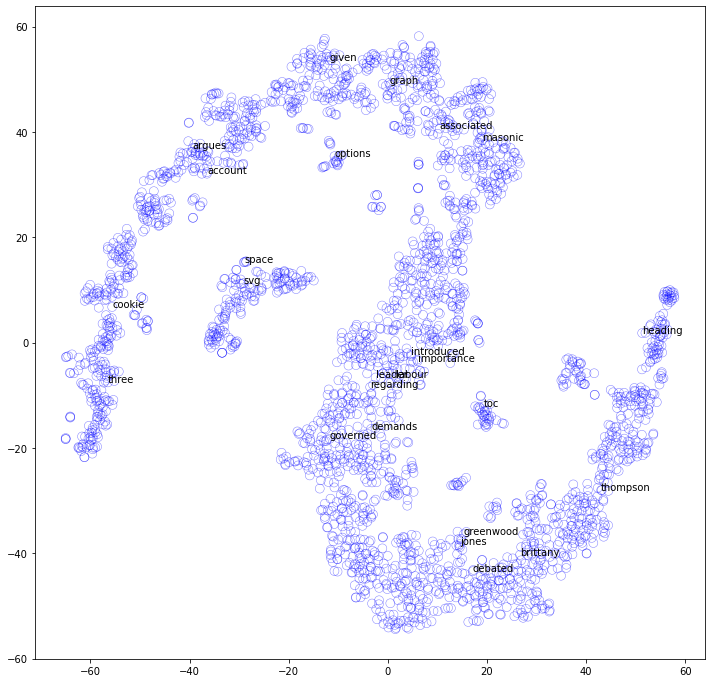

In [ ]:
# Extracción de embeddings y embeddings pre-entrenados.
#!pip install --upgrade --ignore-installed gensim
import gensim
from gensim import corpora
from gensim.utils import simple_preprocess
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import numpy as np

# Embeddings para la colección de juguete del ejercicio 1 (reutilizando la variable "texts").
words = [[word for word in simple_preprocess(text) if word not in stoplist] for text in texts]
model = Word2Vec(words).wv

# !wget https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
#!wget https://huggingface.co/LoganKilpatrick/GoogleNews-vectors-negative300/resolve/main/GoogleNews-vectors-negative300.bin.gz
premodel = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)

print(model.most_similar(['paradox'], topn=20))
print(premodel.most_similar(['paradox'], topn=20))

def reduce_dimensions(model):
  from sklearn.decomposition import IncrementalPCA  # inital reduction
  from sklearn.manifold import TSNE                 # final reduction
  num_dimensions = 2                                # final num dimensions (2D, 3D, etc)
  tsne = TSNE(n_components=num_dimensions, random_state=0)
  vectors = tsne.fit_transform(np.asarray(model.vectors))
  return [v[0] for v in vectors], [v[1] for v in vectors], np.asarray(model.index_to_key)

def plot(x_vals, y_vals, labels):
  import matplotlib.pyplot as plt
  import random
  plt.figure(figsize=(12, 12))
  plt.scatter(x_vals, y_vals, facecolors='none', edgecolors='b', linewidth=.5, s=80, alpha=.5)
  for i in random.sample(list(range(len(labels))), 25): plt.annotate(labels[i], (x_vals[i], y_vals[i]))

plot(*reduce_dimensions(model))

### Ejercicio: dense retrieval con embeddings.

Definir una función de ránking no supervisado basada en embeddings. Utilizar las implementaciones de gensym y la colección de juguete del ejercicio 1, u otras opciones a elección del estudiante.

In [ ]:
# Código aquí.

# 5. Opcional: deep learning to rank.

Aplicar un modelo de deep learning sobre alguno de los conjuntos de datos de los ejercicios anteriores. Por ejemplo, utilizar alguno de los modelos disponibles en PyTerrier.

In [ ]:
# Código aquí.